## compression2.ipynb

Field-level

In [1]:
import sys
sys.path.insert(0,'../cropseg/')

datasetinfo = { "datadir":"/home/ucfaab0/Desktop/su_african_crops_ghana/",
                "metadatadir":"/home/ucfaab0/Desktop/su_african_crops_ghana/metadata/",
                "dataset":"su_african_crops_ghana",
                "groundcollection":"su_african_crops_ghana_labels",
                "s1collection":"su_african_crops_ghana_source_s1",
                "s2collection":"su_african_crops_ghana_source_s2",
                "groundlabels":"su_african_crops_ghana_labels_id.json",
                "groundmetadata":"su_african_crops_ghana_labels.json",
                "s1metadata":"su_african_crops_ghana_source_s1.json",
                "s2metadata":"su_african_crops_ghana_source_s2.json",
                "groundname":"labels.tif",
                "s1imagename":"source.tif",
                "s2imagename":"source.tif",
                "s2maskname":"cloudmask.tif",
                "groundshape":[64,64],
                "s1shape":[64,64],
                "s2shape":[64,64],
                "extension":"tif"
              }
s1bands = [
            {"band":"vv","idx":0},
            {"band":"vh","idx":1},    
          ]  
s2bands = [
            {"band":"blue","wavelength":490,"idx":0},
            {"band":"green","wavelength":560,"idx":1},
            {"band":"red","wavelength":665,"idx":2},
            {"band":"rded1","wavelength":705,"idx":3},
            {"band":"rded2","wavelength":740,"idx":4},
            {"band":"rded3","wavelength":783,"idx":5},
            {"band":"nir","wavelength":842,"idx":6},
            {"band":"rded4","wavelength":865,"idx":7},
            {"band":"swir1","wavelength":1610,"idx":8},
            {"band":"swir2","wavelength":2190,"idx":9}
          ]
s1indices = ["vhvv"]
s2indices = ["ndvi","rdedci","ndmi"]

from mlhubdata import loadjson
groundlabels = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["groundlabels"]}')
groundmetadata = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["groundmetadata"]}')
s1metadata = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["s1metadata"]}')
s2metadata = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["s2metadata"]}')

skiplist = ["001268","002382","003146","003803"]

In [2]:
#####
erosioniterations = 1
ndctcoeff = 6
ndlcoeff = 6
percentile = 60
minpixel = 10
#####

import numpy
from osgeo import gdal
import scipy.interpolate

from grounddata import erodedfieldmasks
from mlhubdata import get_tileitems_from_collection
from satellitedata import load_satellite_data_as_array
from satellitedata import load_satellite_cloudmasks_as_array
from compression import dct
from compression import dct_fittingconditions
from compression import doublelogistic
from compression import doublelogistic_fittingconditions
from compression import doublelogistic_parameterconditions
from miscellaneous import fusedataandweight
from dates import datepositions

coeffs = []
for i in range(len(groundmetadata)):
    tileid = groundmetadata[i]["id"].split("_")[len(groundmetadata[i]["id"].split("_"))-1]
    print(i+1,"/",len(groundmetadata),tileid,end="\r")
    if tileid not in skiplist:
        tilehandle = gdal.Open(f'{datasetinfo["datadir"]}{datasetinfo["groundcollection"]}/{datasetinfo["groundcollection"]}_{tileid}/{datasetinfo["groundname"]}')
        tiledata = numpy.array(tilehandle.GetRasterBand(1).ReadAsArray(),dtype="int")
        crops = numpy.unique(tiledata[tiledata != 0])
        fieldmasks = erodedfieldmasks(tiledata,erosioniterations)
        #
        s1items,s1dates = get_tileitems_from_collection(tileid,s1metadata,datasetinfo,verbose=0)
        s1data = load_satellite_data_as_array(s1items,s1bands,s1indices,datasetinfo,datasetinfo["s1shape"])
        s2items,s2dates = get_tileitems_from_collection(tileid,s2metadata,datasetinfo,verbose=0)
        s2data = load_satellite_data_as_array(s2items,s2bands,s2indices,datasetinfo,datasetinfo["s2shape"],rr=4096.)
        s2cloudmasks = load_satellite_cloudmasks_as_array(s2items,datasetinfo,datasetinfo["s2shape"])
        #
        for j in range(len(fieldmasks)):
            for k in range(fieldmasks[j][1]):
                coeff = []
                for m in range(len(s1indices)):
                    data = []
                    dates = []
                    position = len(s1bands) + m
                    for n in range(len(s1items)):
                        fm = numpy.copy(fieldmasks[j][0])
                        if len(s1data[n][position][fm == k+1]) > 0:
                            data.append(numpy.nanpercentile(s1data[n][position][fm == k+1],percentile))
                            dates.append(s1dates[n])
                    if len(data) >= minpixel:
                        data = numpy.array(data)
                        dpos = numpy.array(datepositions(dates))                
                        if numpy.isnan(numpy.sum(data)) == False and numpy.min(data) > -15.0 and numpy.max(data) < 0.0:
                            if dct_fittingconditions(dpos,data,minduration=0.9,maxgap=0.33) == True:
                                dctcoeff = list(dct(data,ndctcoeff))
                                coeff = coeff + dctcoeff
                #
                for m in range(len(s2indices)):
                    data = []
                    dates = []
                    position = len(s2bands) + m
                    for n in range(len(s2items)):
                        fm = numpy.copy(fieldmasks[j][0])
                        cm = numpy.copy(s2cloudmasks[n])
                        fm[cm != 0] = 0                    
                        if len(s2data[n][position][fm == k+1]) > 0:
                            data.append(numpy.nanpercentile(s2data[n][position][fm == k+1],percentile))
                            dates.append(s2dates[n])
                    if len(dates) >= minpixel:
                        data = numpy.array(data)
                        dates = numpy.array(datepositions(dates))                
                        if doublelogistic_fittingconditions(dates,data,durationmin=0.9,gapmax=0.33,amplitudemin=0.25) == True:
                            spline = scipy.interpolate.UnivariateSpline(dates,data,s=0.01,k=3)
                            splinedates = numpy.linspace(numpy.min(dates),numpy.max(dates),100)
                            fuseddates,fusedmean,fusedweights = fusedataandweight(dates,data,splinedates,spline(splinedates))                    
                            dbllog = doublelogistic(fuseddates,fusedmean,weights=fusedweights,bound=True,epsilon=0.1)
                            if s2indices[m] == "ndvi":
                                if doublelogistic_parameterconditions(dbllog,A1min=0.11,A1max=0.24,A2min=0.26,A2max=0.63,x01min=0.34,x01max=0.88,k1min=7.65,k1max=54.02,x02min=0.61,x02max=1.08,k2min=-43.89,k2max=-16.52) == True:
                                    dbllog = list(dbllog)
                                    coeff = coeff + dbllog
                            if s2indices[m] == "rdedci":
                                if doublelogistic_parameterconditions(dbllog,A1min=0.17,A1max=0.41,A2min=0.52,A2max=1.80,x01min=0.34,x01max=0.86,k1min=9.73,k1max=60.25,x02min=0.59,x02max=1.07,k2min=-45.27,k2max=-10.78) == True:
                                    dbllog = list(dbllog)
                                    coeff = coeff + dbllog
                            if s2indices[m] == "ndmi":
                                if doublelogistic_parameterconditions(dbllog,A1min=-0.22,A1max=-0.09,A2min=0.15,A2max=0.49,x01min=0.34,x01max=0.96,k1min=7.88,k1max=84.59,x02min=0.62,x02max=1.08,k2min=-101.88,k2max=-25.03) == True:                                    
                                    dbllog = list(dbllog)
                                    coeff = coeff + dbllog
                coeff.insert(0,crops[j])
                if len(coeff) == ((len(s1indices)*ndctcoeff)+(len(s2indices)*ndlcoeff)+1):
                    coeffs.append(coeff)
coeffs = numpy.array(coeffs)

../cropseg/satellitedata.py:15: RuntimeWarning: invalid value encountered in true_divide
  return (data[nir] - data[red]) / (data[nir] + data[red])
../cropseg/satellitedata.py:27: RuntimeWarning: invalid value encountered in true_divide
  return (data[nir] / data[reded1]) - 1
../cropseg/satellitedata.py:31: RuntimeWarning: invalid value encountered in true_divide
  return (data[nir] - data[swir1]) / (data[nir] + data[swir1])


../cropseg/compression.py:13: RuntimeWarning: overflow encountered in exp
  return A1+A2*(1./(1+numpy.exp(-k1*(x-x01)))-1./(1+numpy.exp(k2*(x-x02))))


/home/ucfaab0/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


../cropseg/satellitedata.py:27: RuntimeWarning: divide by zero encountered in true_divide
  return (data[nir] / data[reded1]) - 1
/home/ucfaab0/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


PC  stddev varprop
PC1 2.1117 0.1858
PC2 1.6974 0.1200
PC3 1.5908 0.1054
PC4 1.4939 0.0930
PC5 1.3859 0.0800
PC6 1.1374 0.0539
PC7 1.0830 0.0489
PC8 1.0347 0.0446
PC9 0.9997 0.0416
PC10 0.9515 0.0377
PC11 0.8855 0.0327
PC12 0.8072 0.0271
PC13 0.7517 0.0235
PC14 0.7098 0.0210
PC15 0.6927 0.0200
PC16 0.5770 0.0139
PC17 0.5479 0.0125
PC18 0.5266 0.0116
PC19 0.4911 0.0101
PC20 0.4007 0.0067
PC21 0.3179 0.0042
PC22 0.2572 0.0028
PC23 0.2131 0.0019
PC24 0.1583 0.0010


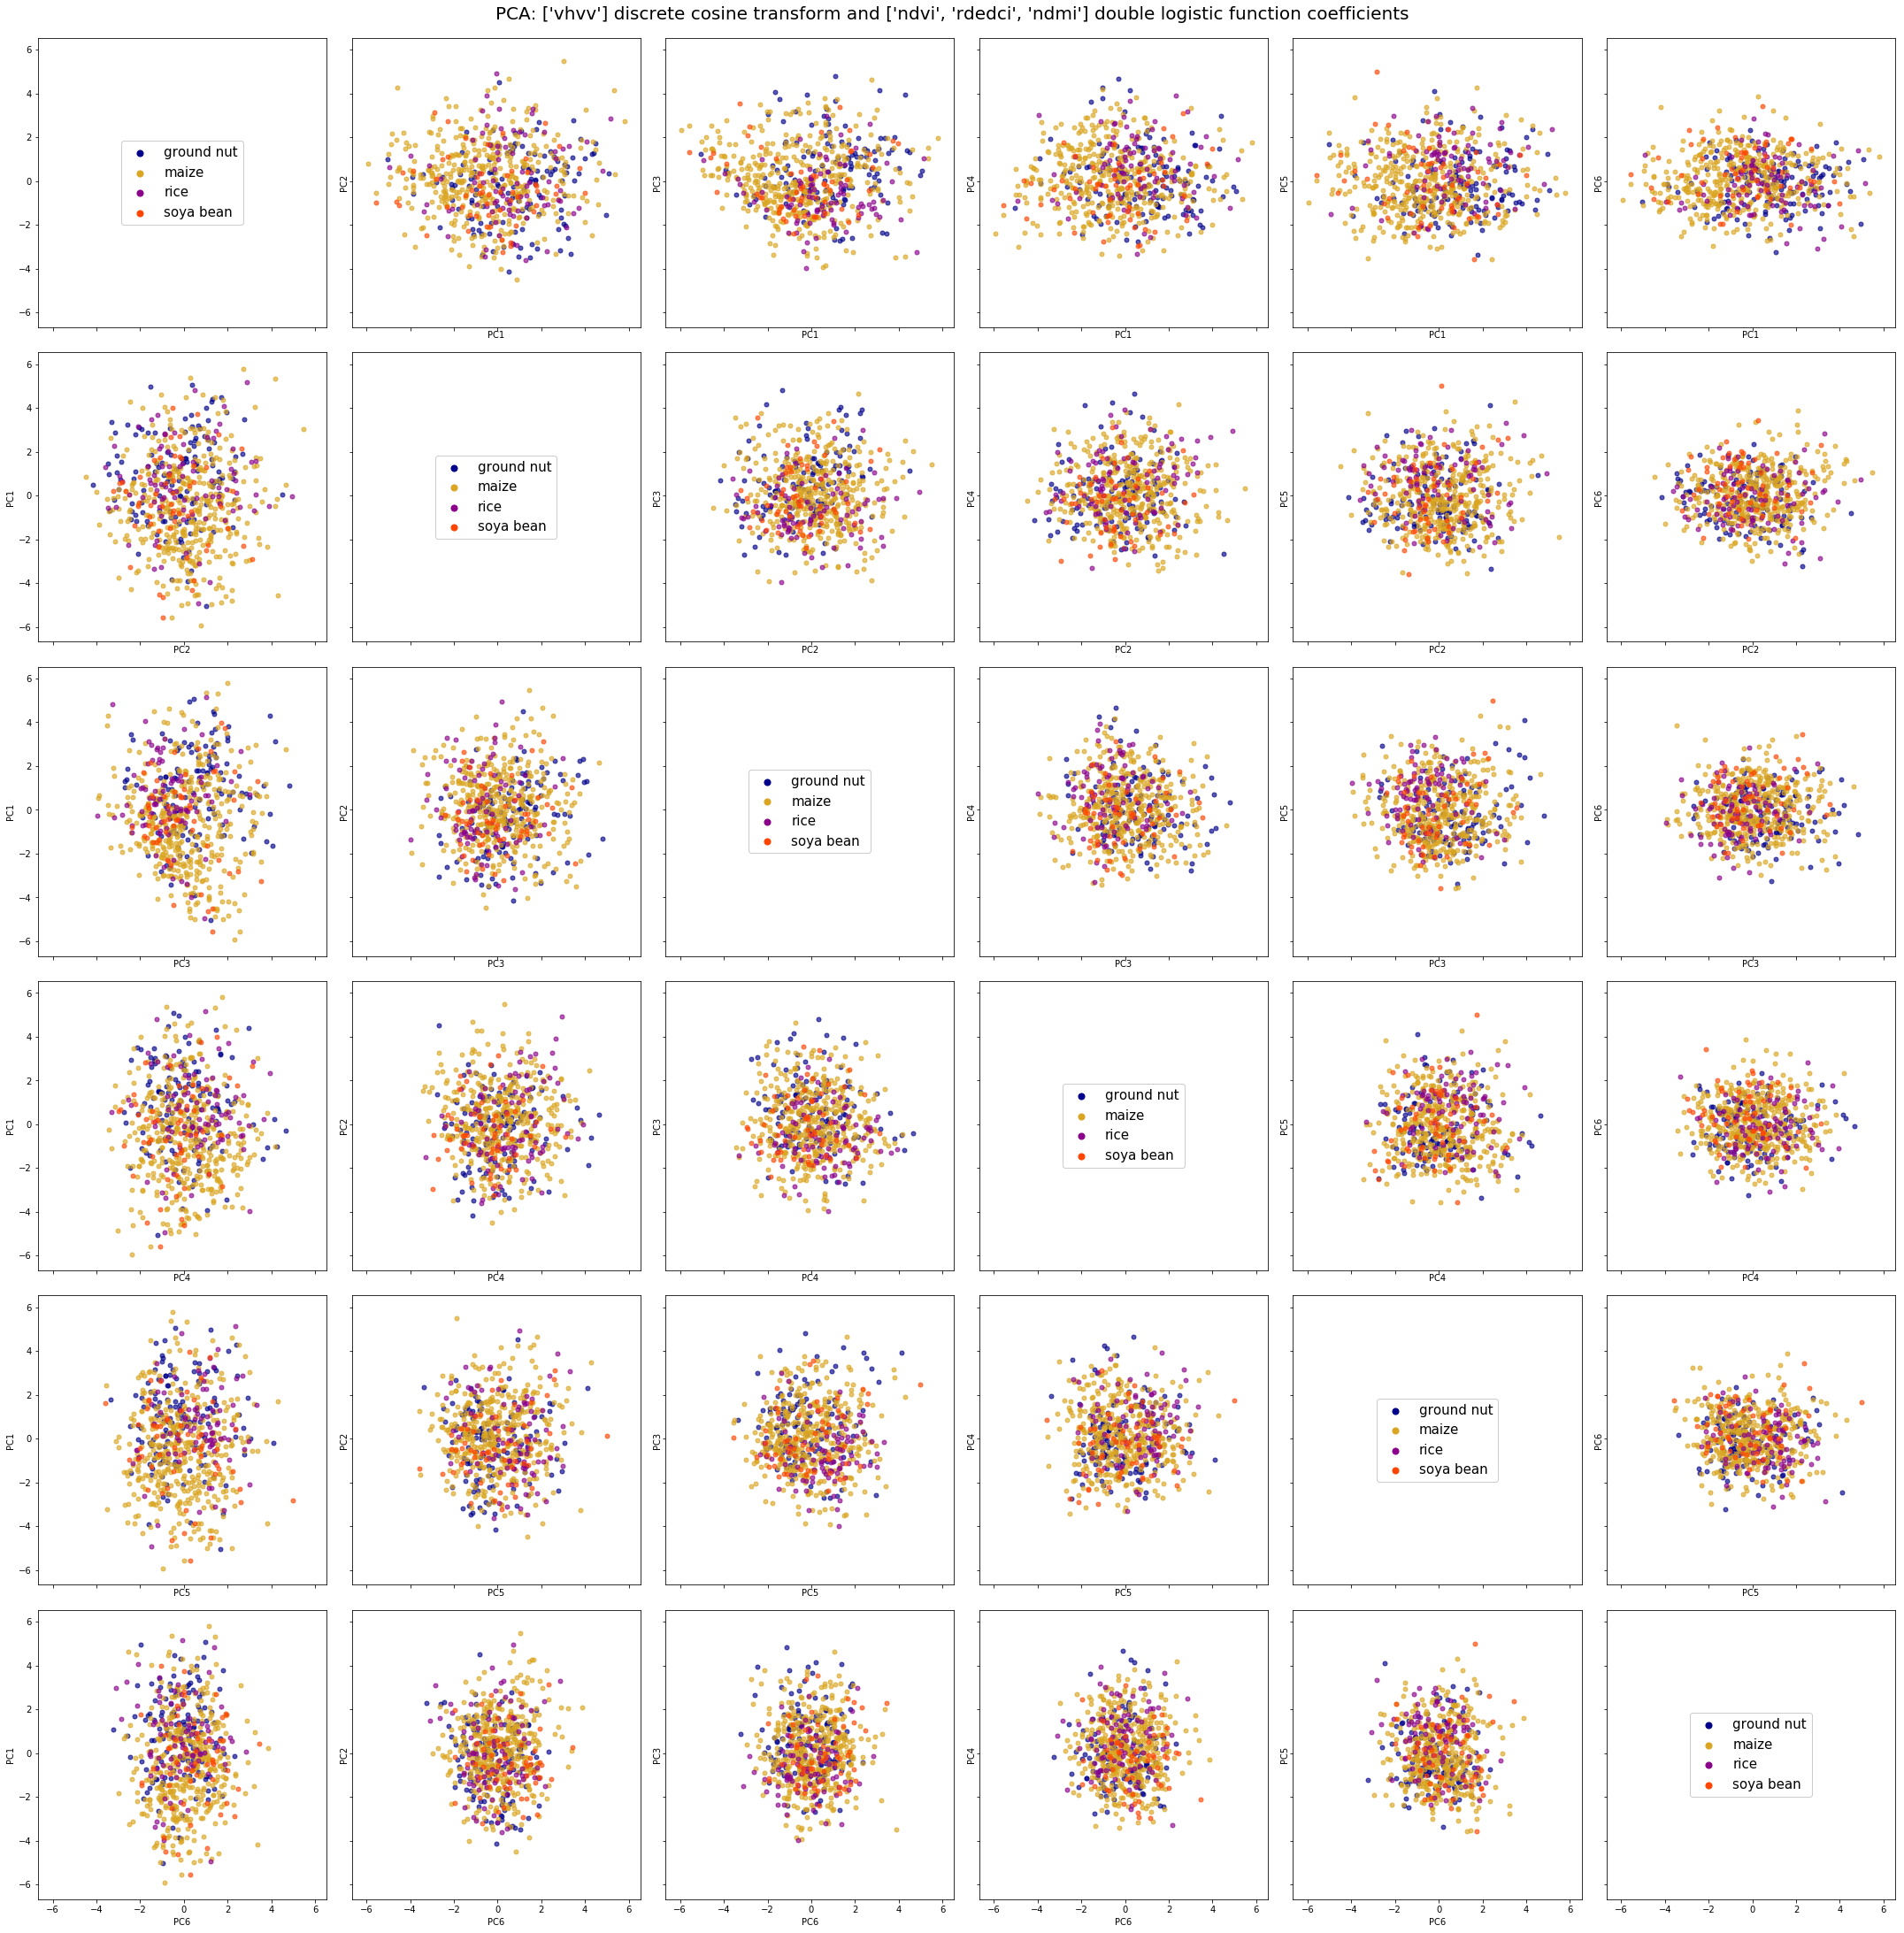

In [4]:
#####
npca = 6
#####

import sklearn.preprocessing
import sklearn.decomposition

import matplotlib.pyplot

y = coeffs[:,0]
X = coeffs[:,1:]
X = sklearn.preprocessing.scale(X)
pca = sklearn.decomposition.PCA().fit(X)
X_pca = pca.transform(X)
varprop = pca.explained_variance_ratio_
stddev = numpy.std(X_pca,axis=0)
print("PC"," stddev", "varprop")
for i in range(len(varprop)):
    print(f"PC{i+1}","{:.4f}".format(stddev[i]),"{:.4f}".format(varprop[i]))
    
crops = numpy.unique(numpy.array(y,dtype="int"))
crops = crops[:4]
fig,ax = matplotlib.pyplot.subplots(npca,npca,figsize=[30,30],sharex="all",sharey="all")
axs = ax.ravel()
idx = 0
for i in range(npca):
    for j in range(npca):
        if i == j:
            for k in range(len(crops)):
                axs[idx].scatter(0,0,color=groundlabels[crops[k]]["colour"],s=50,alpha=1,label=f'{groundlabels[crops[k]]["crop"]}',zorder=-10)
            axs[idx].legend(loc="center",fontsize=15,framealpha=1)
        if i != j:
            axs[idx].set_xlabel(f"PC{i+1}")
            axs[idx].set_ylabel(f"PC{j+1}")
            for k in range(len(crops)):
                axs[idx].scatter(X_pca[:,i][y==crops[k]],X_pca[:,j][y==crops[k]],color=groundlabels[crops[k]]["colour"],s=25,alpha=0.66)
        idx = idx + 1
matplotlib.pyplot.suptitle(f'PCA: {s1indices} discrete cosine transform and {s2indices} double logistic function coefficients',y=1.01,fontsize=20)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

PC  stddev varprop
PC1 2.1117 0.1858
PC2 1.6974 0.1200
PC3 1.5908 0.1054
PC4 1.4939 0.0930
PC5 1.3859 0.0800
PC6 1.1374 0.0539
PC7 1.0830 0.0489
PC8 1.0347 0.0446
PC9 0.9997 0.0416
PC10 0.9515 0.0377
PC11 0.8855 0.0327
PC12 0.8072 0.0271
PC13 0.7517 0.0235
PC14 0.7098 0.0210
PC15 0.6927 0.0200
PC16 0.5770 0.0139
PC17 0.5479 0.0125
PC18 0.5266 0.0116
PC19 0.4911 0.0101
PC20 0.4007 0.0067
PC21 0.3179 0.0042
PC22 0.2572 0.0028
PC23 0.2131 0.0019
PC24 0.1583 0.0010


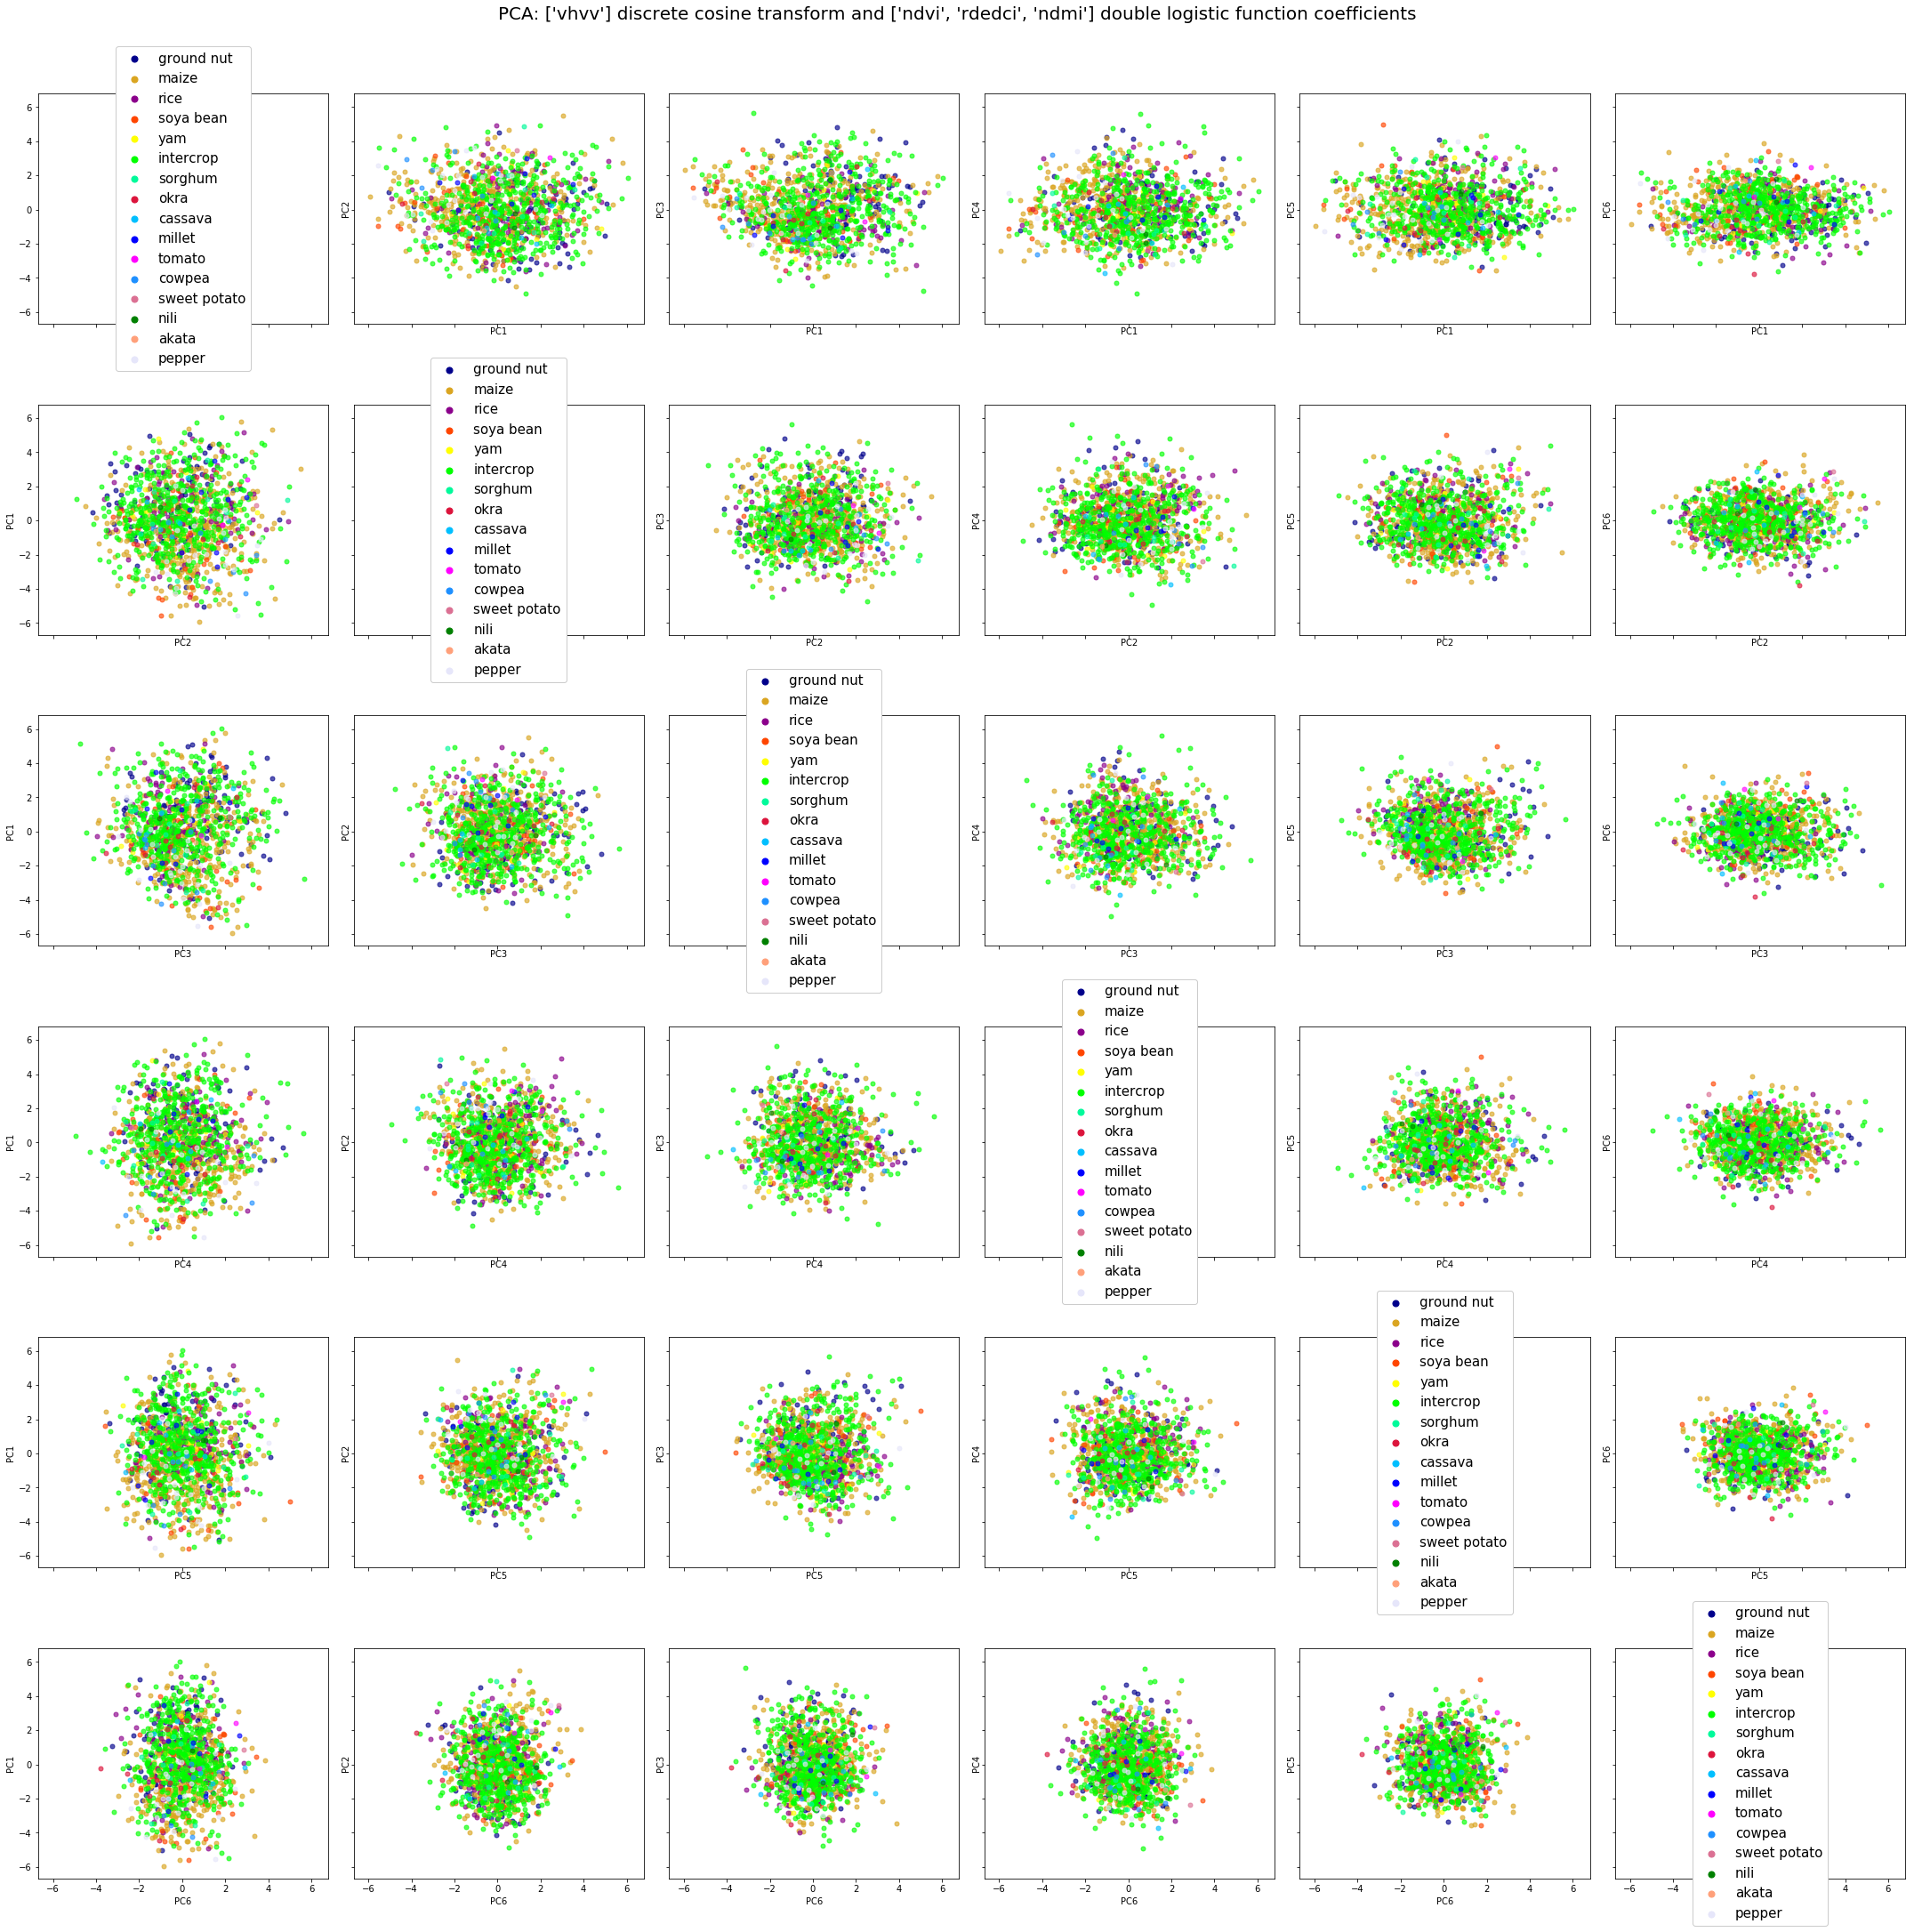

In [5]:
#####
npca = 6
#####

import sklearn.preprocessing
import sklearn.decomposition

import matplotlib.pyplot

y = coeffs[:,0]
X = coeffs[:,1:]
X = sklearn.preprocessing.scale(X)
pca = sklearn.decomposition.PCA().fit(X)
X_pca = pca.transform(X)
varprop = pca.explained_variance_ratio_
stddev = numpy.std(X_pca,axis=0)
print("PC"," stddev", "varprop")
for i in range(len(varprop)):
    print(f"PC{i+1}","{:.4f}".format(stddev[i]),"{:.4f}".format(varprop[i]))
    
crops = numpy.unique(numpy.array(y,dtype="int"))
fig,ax = matplotlib.pyplot.subplots(npca,npca,figsize=[30,30],sharex="all",sharey="all")
axs = ax.ravel()
idx = 0
for i in range(npca):
    for j in range(npca):
        if i == j:
            for k in range(len(crops)):
                axs[idx].scatter(0,0,color=groundlabels[crops[k]]["colour"],s=50,alpha=1,label=f'{groundlabels[crops[k]]["crop"]}',zorder=-10)
            axs[idx].legend(loc="center",fontsize=15,framealpha=1)
        if i != j:
            axs[idx].set_xlabel(f"PC{i+1}")
            axs[idx].set_ylabel(f"PC{j+1}")
            for k in range(len(crops)):
                axs[idx].scatter(X_pca[:,i][y==crops[k]],X_pca[:,j][y==crops[k]],color=groundlabels[crops[k]]["colour"],s=25,alpha=0.66)
        idx = idx + 1
matplotlib.pyplot.suptitle(f'PCA: {s1indices} discrete cosine transform and {s2indices} double logistic function coefficients',y=1.01,fontsize=20)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()